In [68]:
import settings
import helpers
import sys
import os
import glob
import random
import pandas
import ntpath
import cv2
import numpy as np
from tensorflow.keras import backend as K
import math
import pydicom as dicom
from pydicom.encaps import encapsulate
from PIL import Image, ImageDraw
from pydicom.uid import generate_uid, JPEGExtended
from pydicom.dataset import Dataset
from pydicom._storage_sopclass_uids import SecondaryCaptureImageStorage


In [69]:
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
import Train
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.compat.v1.Session(config=config))

In [70]:
pred_labels = pandas.read_csv('F:/Cengiz/Nodules-Detection/prediction/predictions10_luna16_fs/1.3.6.1.4.1.14519.5.2.1.6279.6001.176362912420491262783064585333.csv')
pred_labels.head()

,anno_index,coord_x,coord_y,coord_z,nodule_chance,status,nodule_id
0,0,0.31,0.25,0.2013,0.6326,FP,-1
1,1,0.22,0.34,0.2013,0.6332,FP,-1
2,2,0.19,0.37,0.2013,0.6302,FP,-1
3,3,0.22,0.64,0.2013,0.6201,FP,-1
4,4,0.25,0.34,0.2390,0.6462,FP,-1


In [17]:
pred_labels = pandas.read_csv('F:/Cengiz/NoduleNet/results/cross_val_test/res/200/FROC/submission_rcnn.csv')
pred_labels.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm,probability
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,22.799408,100.119080,129.35155,13.335094,0.983472
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,256.050260,64.401390,200.61462,12.991244,0.761487
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,232.696260,165.385930,305.53143,12.397389,0.268453
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,20.864600,120.656320,109.16142,11.867176,0.206632
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,249.718220,58.302097,205.86046,9.539156,0.145152


In [71]:
def load_patient(src_dir):
    # slices = [dicom.read_file(src_dir + '/' + s) for s in os.listdir(src_dir)]
    slices = []
    print(src_dir)
    for files in glob.glob(src_dir + "/*.dcm"):
        slices.append(dicom.read_file(files))
    print(len(slices))
    slices.sort(key=lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        #print(len(slices))
        slice_thickness = np.abs(slices[5].SliceLocation - slices[6].SliceLocation)
    if slice_thickness == 0:
        slice_thickness = np.abs(slices[4].ImagePositionPatient[2] - slices[5].ImagePositionPatient[2])
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(float)
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number]
        image[slice_number] += intercept

    return np.array(image, dtype=np.float64)


In [72]:
INPUT_DICOM_PATH = 'D:/LIDC-IDRI/LIDC-IDRI-0197/1.3.6.1.4.1.14519.5.2.1.6279.6001.166470028796367356611092393530/1.3.6.1.4.1.14519.5.2.1.6279.6001.176362912420491262783064585333'
slices = load_patient(INPUT_DICOM_PATH)
pixels = get_pixels_hu(slices)
image = pixels
invert_order = slices[1].ImagePositionPatient[2] > slices[0].ImagePositionPatient[2]
print("Invert order: ", invert_order, " - ", slices[1].ImagePositionPatient[2], ",",
      slices[0].ImagePositionPatient[2])
# TODO: Standarize and normalize data
pixel_spacing = slices[0].PixelSpacing
pixel_spacing.append(slices[0].SliceThickness)
print("Slice thik: ", slices[0].SliceThickness)
#print("Dir Path: ", dir_path)
#image = helpers.rescale_patient_images(image, pixel_spacing, 1.00)
if not invert_order:
    image = np.flipud(image)
segmentation = False
shape_image = image.shape
nodules_coord = []
slices_nod_num = []
#(326, 231, 318)
for index, row in pred_labels.iterrows():
    if segmentation:
        coord_z = (row['coord_z']*333) * shape_image[0]
        coord_z = int(round(coord_z))
        coord_y = (row['coord_y']*366) * shape_image[2]
        coord_y = int(round(coord_y))
        coord_x = (row['coord_x']*366) * shape_image[1]
        coord_x = int(round(coord_x))
        diameter = row['diameter_mm']
        diameter = int(round(diameter))
        nodules_coord.append([coord_x,coord_y,coord_z,diameter])
        slices_nod_num.append(coord_z)
    else:      
        coord_z = row['coord_z'] * shape_image[0]
        coord_z = int(round(coord_z))
        coord_y = row['coord_y'] * shape_image[2]
        coord_y = int(round(coord_y))
        coord_x = row['coord_x'] * shape_image[1]
        coord_x = int(round(coord_x))
        nodules_coord.append([coord_x,coord_y,coord_z])
        slices_nod_num.append(coord_z)
print(nodules_coord)
#nodules_coord = post_process_coord
slices_nod_num = []
for row in nodules_coord:
    slices_nod_num.append(row[2])

D:/LIDC-IDRI/LIDC-IDRI-0197/1.3.6.1.4.1.14519.5.2.1.6279.6001.166470028796367356611092393530/1.3.6.1.4.1.14519.5.2.1.6279.6001.176362912420491262783064585333
127
Invert order:  False  -  -24.500000 , -22.000000
Slice thik:  2.5
[[159, 128, 26], [113, 174, 26], [97, 189, 26], [113, 328, 26], [128, 174, 30], [113, 189, 30], [97, 251, 30], [389, 312, 30], [236, 143, 35], [174, 159, 35], [236, 159, 35], [143, 174, 35], [128, 189, 35], [113, 220, 35], [404, 251, 35], [189, 266, 35], [174, 282, 35], [128, 297, 35], [159, 297, 35], [389, 297, 35], [358, 312, 35], [374, 312, 35], [174, 189, 40], [189, 189, 40], [205, 189, 40], [220, 189, 40], [236, 189, 40], [143, 205, 40], [205, 236, 40], [174, 251, 40], [374, 266, 40], [374, 282, 40], [420, 266, 45], [389, 297, 45], [297, 205, 50], [404, 266, 50], [420, 266, 50], [236, 189, 54], [297, 143, 59], [266, 159, 59], [312, 159, 59], [282, 159, 64], [297, 174, 64], [282, 174, 69], [374, 266, 69], [374, 282, 69], [374, 266, 73], [143, 282, 73], [374,

In [24]:
slices_org_num = []
nodules_coord = []
patient_id = '1.3.6.1.4.1.14519.5.2.1.6279.6001.176362912420491262783064585333'
patient_img = helpers.load_patient_images(patient_id, settings.LIDC_EXTRACTED_IMAGE_DIR, "*_i.png", [])
print(patient_img.shape)
for index, row in pred_labels.iterrows():
    p_x,p_y,slice_num = helpers.percentage_to_pixels(row['coord_x'], row['coord_y'], row['coord_z'], patient_img)
    nodules_coord.append([p_x,p_y,slice_num])
    slices_org_num.append(slice_num)
nodules_coord = post_process_coord
print(nodules_coord)
slices_nod_num = []
for row in nodules_coord:
    if row[2] < 40:
        continue
    slices_nod_num.append(row[2])

(318, 400, 400)
[]


In [26]:
print(shape_image)
HEIGHT = 512
WIDTH = 512
print(slices_nod_num)

(127, 512, 512)
[26, 26, 26, 26, 30, 30, 30, 30, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 45, 45, 50, 50, 50, 54, 59, 59, 59, 64, 64, 69, 69, 69, 73, 73, 73, 73, 78, 78, 78, 78, 83, 83, 83, 97, 97, 97, 97, 97, 102, 102, 102, 102, 102, 102, 102, 102, 102, 107, 107, 107, 107, 107]


In [51]:
def apply_ct_window(img, window):
    # window = (window width, window level)
    R = (img-window[1]+0.5*window[0])/window[0]
    R[R<0] = 0
    R[R>1] = 1
    return R
def normalize(image):
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image > 1] = 1.
    image[image < 0] = 0.
    return image
#img = image[0]
#print(img.shape)
#display_img = apply_ct_window(img, [400,-1000])
#display_img = normalize(img)
#ds = slices[0]
def ensure_even(stream):
    # Very important for some viewers
    if len(stream) % 2:
        return stream + b"\x00"
    return stream

In [82]:
for count in range(image.shape[0]):
    #display_img = normalize(img)
    #pixels = get_pixels_hu([slice_])
    #image = patient_img[slice_]
    #img = image[0]
    #print(img.shape)
    #ds = slices[count]
    if not invert_order:
        save_count = image.shape[0] - count
    ds = slices[save_count-1]
    normalized_image = normalize(image[count])
    if count in slices_nod_num: #and count==69:
        for coord in nodules_coord:
            if count == coord[2]:
                if segmentation:
                    top, left, bottom, right = [coord[1]-coord[3]/2,coord[0]-coord[3]/2,coord[1]+coord[3]/2,coord[0]+coord[3]/2]
                else:
                    top, left, bottom, right = [coord[1]-16,coord[0]-16,coord[1]+16,coord[0]+16]
                #top, left, bottom, right = [211,99,291,158]
                thickness = 2
                img_bbox = Image.fromarray((255*normalized_image).astype('uint8'))
                #img_bbox = Image.fromarray(normalized_image)
                img_bbox = img_bbox.convert('RGB')
                #rect = Image.new ('RGB', img_bbox.size)
                draw = ImageDraw.Draw(img_bbox)
                for i in range(thickness):
                    draw.rectangle(
                        [left + i, top + i, right - i, bottom - i],
                        outline=(255,0,0) #transperency 125 (1255)
                    )
                del draw
                #print(count)
                #img_bbox = Image.alpha_composite(img_bbox,rect)
                img_bbox = np.asarray(img_bbox)
                normalized_image = img_bbox/255.0
                # modify DICOM tags
                
                ds.PhotometricInterpretation = 'RGB'
                ds.SamplesPerPixel = 3
                ds.BitsAllocated = 8
                ds.BitsStored = 8
                ds.HighBit = 7
                ds.SeriesNumber = 53
                #ds.add_new(0x00280006, 'US', 0)
                ds.is_little_endian = True
                #ds.SliceLocation = str(save_count)
                ds.InstanceNumber = str(save_count)
                ds.is_implicit_VR = True
                #ds.Modality = "OT"
                ds.SOPInstanceUID = generate_uid()
                ds.Rows = HEIGHT
                ds.Columns = WIDTH
                ds.PixelRepresentation = 0
               # ds.AcquisitionNumber = '9'
                #ds.SeriesInstanceUID = '1.3.6.1.4.1.14519.5.2.1.6279.6001.1763629124204912627830645853331'
                #ds.StudyInstanceUID = '1.3.6.1.4.1.14519.5.2.1.6279.6001.101493103577576219860121359500'

                ds.SOPClassUID = SecondaryCaptureImageStorage

                ds.fix_meta_info()
                #ds.fix_meta_info()
                
                # save pixel data and dicom file
                ds.PixelData = encapsulate([ensure_even(img_bbox.tobytes())])
                ds.save_as('dicom_nodules/'+str(save_count)+'.dcm')
                #ds = dicom.read_file('dicom_nodules/'+str(save_count)+'.dcm',force=True)
                #pixels = get_pixels_hu([ds])
                #image = pixels
                #img = image[0]
    else:
        img_bbox = Image.fromarray((255*normalized_image).astype('uint8'))
        img_bbox = img_bbox.convert('RGB')
        img_bbox = np.asarray(img_bbox)

        # modify DICOM tags
        ds.PhotometricInterpretation = 'RGB'
        ds.SamplesPerPixel = 3
        ds.BitsAllocated = 8
        ds.BitsStored = 8
        ds.HighBit = 7
        ds.SeriesNumber = 53
        ds.is_implicit_VR = True
        #ds.add_new(0x00280006, 'US', 0)
        ds.is_little_endian = True
        ds.InstanceNumber = str(save_count)
        ds.SOPInstanceUID = generate_uid()
        ds.Rows = HEIGHT
        ds.Columns = WIDTH
        ds.PixelRepresentation = 0
        #ds.AcquisitionNumber = '2'
        #ds.SeriesInstanceUID = '5'
        #ds.StudyInstanceUID = '1.3.6.1.4.1.14519.5.2.1.6279.6001.101493103577576219860121359500'
        #ds.SeriesInstanceUID = '1.3.6.1.4.1.14519.5.2.1.6279.6001.1763629124204912627830645853331'

        ds.SOPClassUID = SecondaryCaptureImageStorage
        ds.fix_meta_info()
        #ds.fix_meta_info()

        # save pixel data and dicom file
        ds.PixelData = encapsulate([ensure_even(img_bbox.tobytes())])
        ds.save_as('dicom_nodules/'+str(save_count)+'.dcm')

In [34]:
for slice_ in range(patient_img.shape[0]):
    #display_img = normalize(img)
    #pixels = get_pixels_hu([slice_])
    image = patient_img[slice_]
    #img = image[0]
    #print(img.shape)
    ds = Dataset()
    ds = slices[0]
    if not invert_order:
        save_count = image.shape[0] - count
    normalized_image = normalize(image[count])
    #normalized_image = image
    if slice_ in slices_org_num:
        for coord in nodules_coord:
            if slice_ == coord[2]:
                top, left, bottom, right = [coord[1]-15,coord[0]-15,coord[1]+15,coord[0]+15]
                #top, left, bottom, right = [211,99,291,158]
                thickness = 2
                #img_bbox = Image.fromarray((255*normalized_image).astype('uint8'))
                img_bbox = Image.fromarray(normalized_image)
                img_bbox = img_bbox.convert('RGB')
                #rect = Image.new ('RGB', img_bbox.size)
                draw = ImageDraw.Draw(img_bbox)
                for i in range(thickness):
                    draw.rectangle(
                        [left + i, top + i, right - i, bottom - i],
                        outline=(255,0,0) #transperency 125 (1255)
                    )
                del draw
                #print(slice_)
                #img_bbox = Image.alpha_composite(img_bbox,rect)
                img_bbox = np.asarray(img_bbox)

                # modify DICOM tags
                ds.PhotometricInterpretation = 'RGB'
                ds.SamplesPerPixel = 3
                ds.BitsAllocated = 8
                ds.BitsStored = 8
                ds.HighBit = 7
                ds.SeriesNumber = 50
                ds.add_new(0x00280006, 'US', 0)
                ds.is_little_endian = True
                ds.is_implicit_VR = True
                ds.Modality = "OT"
                ds.SOPInstanceUID = generate_uid()
                ds.Rows = HEIGHT
                ds.Columns = WIDTH
                ds.PixelRepresentation = 0

                ds.SOPClassUID = SecondaryCaptureImageStorage
                ds.StudyInstanceUID = '1.3.6.1.4.1.14519.5.2.1.6279.6001.101493103577576219860121359500'

                ds.fix_meta_info()
                #ds.fix_meta_info()

                # save pixel data and dicom file
                ds.PixelData = encapsulate([ensure_even(img_bbox.tobytes())])
                ds.save_as('dicom_nodules/'+str(slice_)+'.dcm')
                #ds = dicom.read_file('dicom_nodules/'+str(slice_)+'.dcm',force=True)
                #pixels = get_pixels_hu([ds])
                #image = pixels
                #img = image[0]
    else:
        img_bbox = Image.fromarray(normalized_image)
        img_bbox = img_bbox.convert('RGB')
        img_bbox = np.asarray(img_bbox)

        # modify DICOM tags
        ds.PhotometricInterpretation = 'RGB'
        ds.SamplesPerPixel = 3
        ds.BitsAllocated = 8
        ds.BitsStored = 8
        ds.HighBit = 7
        ds.SeriesNumber = 50
        ds.is_implicit_VR = True
        ds.add_new(0x00280006, 'US', 0)
        ds.is_little_endian = True
        ds.SOPInstanceUID = generate_uid()
        ds.Rows = HEIGHT
        ds.Columns = WIDTH
        ds.PixelRepresentation = 0
        ds.StudyInstanceUID = '1.3.6.1.4.1.14519.5.2.1.6279.6001.101493103577576219860121359500'

        ds.SOPClassUID = SecondaryCaptureImageStorage
        ds.fix_meta_info()
        #ds.fix_meta_info()

        # save pixel data and dicom file
        ds.PixelData = encapsulate([ensure_even(img_bbox.tobytes())])
        ds.save_as('dicom_nodules/'+str(slice_)+'.dcm')

In [ ]:
top, left, bottom, right = [211,99,291,158]
thickness = 4
img_bbox = Image.fromarray((255*display_img).astype('uint8'))
img_bbox = img_bbox.convert('RGB')
draw = ImageDraw.Draw(img_bbox)
for i in range(thickness):
    draw.rectangle(
        [left + i, top + i, right - i, bottom - i],
        outline=(255,0,0)
    )
del draw
img_bbox = np.asarray(img_bbox)

# modify DICOM tags
ds.PhotometricInterpretation = 'RGB'
ds.SamplesPerPixel = 3
ds.BitsAllocated = 8
ds.BitsStored = 8
ds.HighBit = 7
ds.add_new(0x00280006, 'US', 0)
ds.is_little_endian = True
ds.fix_meta_info()

# save pixel data and dicom file
ds.PixelData = img_bbox.tobytes()
ds.save_as('test.dcm')

In [5]:
A= np.array([[[ 1.01551435, -0.76494131],
 [ 0.56853752 , 1.94491724]],
[[-0.97433012 , 2.08134198],
 [-1.34997602 ,-0.33543117]],
[[ 0.54217072, -1.33470658],
 [-0.50179028, -0.66593918]]])
B = np.flipud(A)
print(A,B)

[[[ 1.01551435 -0.76494131]
  [ 0.56853752  1.94491724]]

 [[-0.97433012  2.08134198]
  [-1.34997602 -0.33543117]]

 [[ 0.54217072 -1.33470658]
  [-0.50179028 -0.66593918]]] [[[ 0.54217072 -1.33470658]
  [-0.50179028 -0.66593918]]

 [[-0.97433012  2.08134198]
  [-1.34997602 -0.33543117]]

 [[ 1.01551435 -0.76494131]
  [ 0.56853752  1.94491724]]]


In [12]:
import copy
def filter_nodules(nodule_list, image_shape):
    #[annotation_index, p_x_perc, p_y_perc, p_z_perc, nodule_chance,status,nod_id]
    #[annotation_index, p_x_perc, p_y_perc, p_z_perc, nodule_chance,status,nod_id]
    unique_list = []
    output_list = []
    for nodule_ in nodule_list:
        if nodule_[0] in unique_list:
            continue
        slice_number = int(round(nodule_[3] * image_shape[0]))
        nodule_per_slice = []
        for nodule in nodule_list:
            if nodule[0] == nodule_[0]:
                #print("Skip nodule ID: ", nodule[0])
                continue
            if slice_number == int(round(nodule[3] * image_shape[0])):
                nodule_per_slice.append((nodule[0],int(round(nodule[1] * image_shape[1])),int(round(nodule[2] * image_shape[2]))))
                #print("Append noduel ID: ", nodule[0])
        if len(nodule_per_slice) == 0:
            "skip empty list"
            continue
        if len(nodule_per_slice) < 1: #controller of the nodules occurance to be expected
            #print("skip nodule reason: FP", "slice number: ", slice_number, " X_coord: ", nodule_per_slice[0][1], " Y_coord: ", nodule_per_slice[0][2])
            continue
        overlapping = []
        print(image_shape[0] - slice_number,len(nodule_per_slice))
        for coord in nodule_per_slice:
            #print(abs(int(round(nodule_[1] * image_shape[1])) - coord[1]), abs(int(round(nodule_[2] * image_shape[2])) - coord[2]))
            if abs(int(round(nodule_[1] * image_shape[1])) - coord[1]) < 32 and abs(int(round(nodule_[2] * image_shape[2])) - coord[2]) < 32:
                unique_list.append(coord[0])
                overlapping.append((coord[1],coord[2]))
        if len(overlapping) == 0:
            continue
        rect_list = []
        overlapping.append((abs(int(round(nodule_[1] * image_shape[1]))), abs(int(round(nodule_[2] * image_shape[2])))))
        #print(len(overlapping))
        print(overlapping)
        for nn in overlapping:
            rect = box(nn[0]-32,nn[1]-32,nn[0]+32,nn[1]+32)
            rect_list.append(rect)

            # find intersection of rectangles (probably a more elegant way to do this)
        #print(len(rect_list))
        rect1 = rect_list[0]
        for rect in rect_list[1:]:
            rect1 = rect1.intersection(rect)
        intersection = rect1
        print(image_shape[0] - slice_number,intersection.bounds)
        out_x = (intersection.bounds[2] - intersection.bounds[0]) /2 + intersection.bounds[0]
        out_y = (intersection.bounds[3] - intersection.bounds[1]) /2 + intersection.bounds[1]
        output_list.append([out_x,out_y,slice_number])
    output_list_modified = output_list
    print(output_list)
    for count_1,content in enumerate(output_list):
        for count_2, repl in enumerate(output_list[count_1+1:]):
            if content[0] == repl[0] and content[1] == repl[1] and abs(content[2] - repl[2]) < 6:
                output_list_modified.pop(count_2+count_1+1)
    output_list_modified_exten = copy.deepcopy(output_list_modified)
    for filtered_nod in output_list_modified:
        output_list_modified_exten.append([filtered_nod[0],filtered_nod[1],filtered_nod[2]-1])
        output_list_modified_exten.append([filtered_nod[0],filtered_nod[1],filtered_nod[2]-2])
        output_list_modified_exten.append([filtered_nod[0],filtered_nod[1],filtered_nod[2]+1])
        output_list_modified_exten.append([filtered_nod[0],filtered_nod[1],filtered_nod[2]+2])
        #output_list_modified_exten.append([filtered_nod[0],filtered_nod[1],filtered_nod[2]+3])

    return output_list_modified_exten
post_process_coord = filter_nodules(pred_labels.values,shape_image)
print(shape_image)
print(post_process_coord)

[]
(127, 512, 512)
[]


In [23]:
from shapely.geometry import box

# make some rectangles (for demonstration purposes and intersect with each other)
rect1 = box(0,0,5,2)
rect2 = box(0.5,0.5,3,3)
#rect3 = box(1.5,1.5,4,6)
#rect3 = box(5,5,8,8)
rect_list = [rect1, rect2]

# find intersection of rectangles (probably a more elegant way to do this)
for rect in rect_list:
    rect1 = rect1.intersection(rect)
intersection = rect1
print(intersection.bounds)

(0.5, 0.5, 3.0, 2.0)


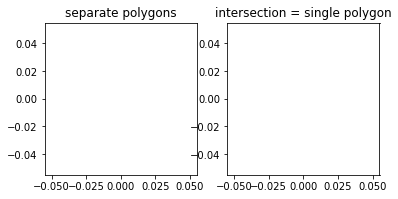

In [45]:
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

# plot the rectangles before and after merging 

patches  = PatchCollection([Polygon(a.exterior) for a in rect_list], facecolor='red', linewidth=.5, alpha=.5)
intersect_patch =  PatchCollection([Polygon(intersection.exterior)], facecolor='red', linewidth=.5, alpha=.5)

# make figure
fig, ax = plt.subplots(1,2, subplot_kw=dict(aspect='equal'))
ax[0].add_collection(patches, autolim=True)
ax[0].autoscale_view()
ax[0].set_title('separate polygons')
ax[1].add_collection(intersect_patch, autolim=True)
ax[1].set_title('intersection = single polygon')
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
plt.show()

In [ ]:
# Coded version of DICOM file '1-242.dcm'
# Produced by pydicom codify utility script
import pydicom
from pydicom.dataset import Dataset, FileMetaDataset
from pydicom.sequence import Sequence

# File meta info data elements
file_meta = FileMetaDataset()
file_meta.FileMetaInformationGroupLength = 204
file_meta.FileMetaInformationVersion = b'\x00\x01'
file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.2'
file_meta.MediaStorageSOPInstanceUID = '1.3.6.1.4.1.14519.5.2.1.6279.6001.385766156882706341236756622820'
file_meta.TransferSyntaxUID = '1.2.840.10008.1.2'
file_meta.ImplementationClassUID = '1.3.6.1.4.1.22213.1.143'
file_meta.ImplementationVersionName = '0.5'
file_meta.SourceApplicationEntityTitle = 'POSDA'

# Main data elements
ds = Dataset()
ds.SpecificCharacterSet = 'ISO_IR 100'
ds.ImageType = ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
ds.SOPClassUID = '1.2.840.10008.5.1.4.1.1.2'
ds.SOPInstanceUID = '1.3.6.1.4.1.14519.5.2.1.6279.6001.385766156882706341236756622820'
ds.StudyDate = '20000101'
ds.SeriesDate = '20000101'
ds.AcquisitionDate = '20000101'
ds.ContentDate = '20000101'
ds.OverlayDate = '20000101'
ds.CurveDate = '20000101'
ds.AcquisitionDateTime = '20000101'
ds.StudyTime = ''
ds.SeriesTime = ''
ds.AcquisitionTime = '103245.056638'
ds.ContentTime = '103245.056638'
ds.AccessionNumber = ''
ds.Modality = 'CT'
ds.Manufacturer = 'SIEMENS'
ds.ReferringPhysicianName = ''
ds.SeriesDescription = 'TAA  3.0  B30f'
ds.ManufacturerModelName = 'Sensation 64'
ds.PatientName = ''
ds.PatientID = 'LIDC-IDRI-0086'
ds.PatientBirthDate = ''
ds.PatientSex = 'M'
ds.PatientAge = '074Y'
ds.PregnancyStatus = 4
ds.LastMenstrualDate = '20000101'
ds.PatientIdentityRemoved = 'YES'
ds.DeidentificationMethod = 'DCM:113100/113105/113107/113108/113109/113111'
ds.ContrastBolusAgent = 'APPLIED'
ds.BodyPartExamined = 'CHEST'
ds.SliceThickness = '3.0'
ds.KVP = '120.0'
ds.DataCollectionDiameter = '500.0'
ds.SoftwareVersions = 'syngo CT 2006A'
ds.ContrastBolusVolume = '0.0'
ds.ContrastFlowRate = '0.0'
ds.ContrastFlowDuration = '0.0'
ds.ContrastBolusIngredientConcentration = '0.0'
ds.ReconstructionDiameter = '379.0'
ds.DistanceSourceToDetector = '1040.0'
ds.DistanceSourceToPatient = '570.0'
ds.GantryDetectorTilt = '0.0'
ds.TableHeight = '171.0'
ds.RotationDirection = 'CW'
ds.ExposureTime = '330'
ds.XRayTubeCurrent = '532'
ds.Exposure = '351'
ds.FilterType = '0'
ds.GeneratorPower = '44'
ds.FocalSpots = '1.2'
ds.DateOfLastCalibration = ''
ds.TimeOfLastCalibration = ''
ds.ConvolutionKernel = 'B30f'
ds.PatientPosition = 'FFS'
ds.StudyInstanceUID = '1.3.6.1.4.1.14519.5.2.1.6279.6001.442836465012574652961690947717'
ds.SeriesInstanceUID = '1.3.6.1.4.1.14519.5.2.1.6279.6001.145580766024236783540879444879'
ds.StudyID = ''
ds.SeriesNumber = '5604'
ds.AcquisitionNumber = '8'
ds.InstanceNumber = '242'
ds.ImagePositionPatient = [-188.1298828125, -360.1298828125, -417]
ds.ImageOrientationPatient = [1, 0, 0, 0, 1, 0]
ds.FrameOfReferenceUID = '1.3.6.1.4.1.14519.5.2.1.6279.6001.315442562659310695946166677985'
ds.PositionReferenceIndicator = ''
ds.SliceLocation = '417.0'
ds.NumberOfStudyRelatedInstances = '250'
ds.SamplesPerPixel = 1
ds.PhotometricInterpretation = 'MONOCHROME2'
ds.Rows = 512
ds.Columns = 512
ds.PixelSpacing = [0.740234375, 0.740234375]
ds.BitsAllocated = 16
ds.BitsStored = 12
ds.HighBit = 11
ds.PixelRepresentation = 0
ds.SmallestImagePixelValue = 0
ds.LargestImagePixelValue = 2713
ds.LongitudinalTemporalInformationModified = 'MODIFIED'
ds.WindowCenter = [40, -500]
ds.WindowWidth = [400, 2000]
ds.RescaleIntercept = '-1024.0'
ds.RescaleSlope = '1.0'
ds.WindowCenterWidthExplanation = ['WINDOW1', 'WINDOW2']
ds.RequestedProcedureDescription = ''
ds.AdmittingDate = '20000101'
ds.ScheduledProcedureStepStartDate = '20000101'
ds.ScheduledProcedureStepEndDate = '20000101'
ds.PerformedProcedureStepStartDate = '20000101'

# Request Attributes Sequence
request_attributes_sequence = Sequence()
ds.RequestAttributesSequence = request_attributes_sequence

# Request Attributes Sequence: Request Attributes 1
request_attributes1 = Dataset()
request_attributes1.ScheduledProcedureStepDescription = 'CT, CHEST, W CONTRAST'
request_attributes1.ScheduledProcedureStepID = '9822700300009440'
request_attributes1.RequestedProcedureID = '9822700300009440'
request_attributes_sequence.append(request_attributes1)

ds.PlacerOrderNumberImagingServiceRequest = ''
ds.FillerOrderNumberImagingServiceRequest = ''
ds.VerifyingObserverName = 'Removed by CTP'
ds.PersonName = 'Removed by CTP'
ds.ContentCreatorName = ''
ds.PixelData = # XXX Array of 524288 bytes excluded

ds.file_meta = file_meta
ds.is_implicit_VR = True
ds.is_little_endian = True
ds.save_as(r'1-242_from_codify.dcm', write_like_original=False)

In [5]:
dicom.codify('./1.3.6.1.4.1.14519.5.2.1.6279.6001.178391668569567816549737454720/dicom_nodules/1.dcm')

AttributeError: module 'pydicom' has no attribute 'codify'